# LLM Factor Analysis - Personality Items (Qwen3-Embedding Models)

Extracts embeddings from NEO personality items using **Qwen3-Embedding models** and compares predicted similarities with observed correlations.

**Available Models:**
- Qwen3-Embedding-0.6B (600M parameters, ~2.4 GB)
- Qwen3-Embedding-4B (4B parameters, ~16 GB) 
- Qwen3-Embedding-8B (8B parameters, ~32 GB)

**Model Configuration:**
- Precision: FP32 (full precision)
- Library: sentence-transformers (simplified API)
- Supports: 100+ languages, MTEB top-ranked performance

**Note:** You can easily enable/disable specific models in the model selection cell below. By default, all three models are enabled.

## Import Dependencies

This notebook requires:
- `sentence-transformers>=2.7.0`
- `transformers>=4.51.0`
- `torch>=2.0.0`

In [1]:
import os
import sys
from datetime import datetime

import pandas as pd
import numpy as np
print("  - pandas and numpy loaded")

import torch
print(f"  - torch {torch.__version__} loaded")

# Check if sentence-transformers is installed
try:
    from sentence_transformers import SentenceTransformer
    import sentence_transformers
    print(f"  - sentence-transformers {sentence_transformers.__version__} loaded")
except ImportError:
    print("\nERROR: sentence-transformers not found!")
    print("Please install: pip install sentence-transformers>=2.7.0")
    raise

# Check transformers version
import transformers
print(f"  - transformers {transformers.__version__} loaded")

  - pandas and numpy loaded
  - torch 2.9.0 loaded


/Users/devon7y/VS Code/LLM Factor Analysis/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  - sentence-transformers 5.1.1 loaded
  - transformers 4.57.1 loaded


## Load and Process Data

In [2]:
print("Loading scale...")
scale = pd.read_csv('scales/DASS_items.csv', usecols=['code', 'item', 'factor'])
print(f"Loaded {len(scale)} items")

# Preview the data
scale.head()

Loading scale...
Loaded 42 items


,code,item,factor
0,S1,I found myself getting upset by quite trivial ...,Stress
1,A2,I was aware of dryness of my mouth.,Anxiety
2,D3,I couldn't seem to experience any positive fee...,Depression
3,A4,"I experienced breathing difficulty (eg, excess...",Anxiety
4,D5,I just couldn't seem to get going.,Depression


In [3]:
# Extract codes, items and factors for easier access
codes = scale['code'].tolist()
items = scale['item'].tolist()
factors = scale['factor'].tolist()

print(f"Total items: {len(items)}")
print(f"Unique factors: {sorted(set(factors))}")
print(f"Sample codes: {codes[:5]}")

Total items: 42
Unique factors: ['Anxiety', 'Depression', 'Stress']
Sample codes: ['S1', 'A2', 'D3', 'A4', 'D5']


## Device Detection and Memory Check

In [4]:
# Detect available device
print("Detecting available device...")
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"✓ Using CUDA GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("✓ Using Apple MPS GPU (Metal Performance Shaders)")
else:
    device = torch.device('cpu')
    print("✓ Using CPU")

# Check available memory (basic check)
try:
    import psutil
    mem = psutil.virtual_memory()
    print(f"\nSystem Memory:")
    print(f"  Total: {mem.total / (1024**3):.1f} GB")
    print(f"  Available: {mem.available / (1024**3):.1f} GB")
    print(f"  Used: {mem.percent}%")
except ImportError:
    print("\n  psutil not installed - skipping memory check")
    print("Install with: pip install psutil")

Detecting available device...
✓ Using Apple MPS GPU (Metal Performance Shaders)

System Memory:
  Total: 16.0 GB
  Available: 6.3 GB
  Used: 60.5%


## Load Qwen3-Embedding Models

**Memory Requirements (FP32 full precision):**
- Qwen3-Embedding-0.6B: ~2.4 GB
- Qwen3-Embedding-4B: ~16 GB
- Qwen3-Embedding-8B: ~32 GB

We'll load and process each model sequentially to analyze how model size affects embedding quality.

In [5]:
# ============================================================================
# MODEL SELECTION - Comment out any models you don't want to run
# ============================================================================
# To disable a model, add a '#' at the start of its line
# To enable a model, remove the '#' from the start of its line
# ============================================================================

model_names = [
    "Qwen/Qwen3-Embedding-0.6B",
    #"Qwen/Qwen3-Embedding-4B", 
    #"Qwen/Qwen3-Embedding-8B"
]

# ============================================================================

# Dictionary to store results
all_embeddings = {}
all_models = {}

print(f"Loading {len(model_names)} Qwen3-Embedding model(s)...")
print("=" * 70)
print(f"Selected models: {[m.split('/')[-1] for m in model_names]}")
print("=" * 70)

for model_name in model_names:
    model_size = model_name.split("-")[-1]
    print(f"\n{'='*70}")
    print(f"Loading {model_name}")
    print(f"{'='*70}")
    print(f"This may take 30-120 seconds depending on model size...")
    
    try:
        # Load model - let sentence-transformers handle device placement automatically
        # Don't use device_map="auto" as it causes meta tensor issues with large models
        model = SentenceTransformer(model_name)
        
        print(f"✓ {model_size} model loaded successfully!")
        print(f"  Device: {model.device}")
        print(f"  Max sequence length: {model.max_seq_length}")
        
        # Check embedding dimension
        test_embedding = model.encode(["test"], convert_to_numpy=True)
        print(f"  Embedding dimension: {test_embedding.shape[1]}")
        
        # Store the model for later use
        all_models[model_size] = model
        
    except Exception as e:
        print(f"\nError loading {model_name}:")
        print(f"  {type(e).__name__}: {str(e)}")
        print(f"  Skipping this model and continuing with others...")
        continue

print(f"\n{'='*70}")
print(f"✓ Successfully loaded {len(all_models)} model(s)!")
print(f"{'='*70}")

Loading 1 Qwen3-Embedding model(s)...
Selected models: ['Qwen3-Embedding-0.6B']

Loading Qwen/Qwen3-Embedding-0.6B
This may take 30-120 seconds depending on model size...
✓ 0.6B model loaded successfully!
  Device: mps:0
  Max sequence length: 32768
  Embedding dimension: 1024

✓ Successfully loaded 1 model(s)!


## Extract Embeddings for All Models

Using sentence-transformers' `encode()` method for each model.

**Processing:**
- Extract embeddings for all personality items with each model
- Using `batch_size=8` for efficient processing
- Results stored in `all_embeddings` dictionary keyed by model size

In [6]:
print(f"Extracting embeddings for {len(items)} personality items using all models...")
print("=" * 70)

for model_size, model in all_models.items():
    print(f"\n{'='*70}")
    print(f"Processing with {model_size} model")
    print(f"{'='*70}")
    
    try:
        # Extract embeddings
        embeddings = model.encode(
            items,
            batch_size=8,  # Process in batches
            show_progress_bar=True,
            convert_to_numpy=True,
            normalize_embeddings=False  # Keep raw embeddings for analysis
        )
        
        # Store results
        all_embeddings[model_size] = embeddings
        
        print(f"\n✓ Embedding extraction complete for {model_size}!")
        print(f"  Shape: {embeddings.shape}")
        print(f"  ({embeddings.shape[0]} items × {embeddings.shape[1]} dimensions)")
        
    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            print(f"\nOut of memory error with {model_size}!")
            print(f"  Try reducing batch_size or using a smaller model")
            raise
        else:
            raise

print(f"\n{'='*70}")
print(f"✓ All embeddings extracted successfully!")
print(f"{'='*70}")
print(f"\nEmbedding dimensions by model:")
for model_size, embeddings in all_embeddings.items():
    print(f"  {model_size}: {embeddings.shape[1]}D")

Extracting embeddings for 42 personality items using all models...

Processing with 0.6B model


Batches: 100%|██████████| 6/6 [00:01<00:00,  4.46it/s]


✓ Embedding extraction complete for 0.6B!
  Shape: (42, 1024)
  (42 items × 1024 dimensions)

✓ All embeddings extracted successfully!

Embedding dimensions by model:
  0.6B: 1024D


## Inspect Embedding Results

In [7]:
# Compare embedding dimensions across models
print("Embedding dimensions by model:")
print("=" * 70)
for model_size, embeddings in all_embeddings.items():
    print(f"\n{model_size}:")
    print(f"  Shape: {embeddings.shape}")
    print(f"  Embedding dimension: {embeddings.shape[1]}D")
    print(f"  First embedding (first 10 values): {embeddings[0][:10]}")

Embedding dimensions by model:

0.6B:
  Shape: (42, 1024)
  Embedding dimension: 1024D
  First embedding (first 10 values): [ 0.01202668 -0.0104402  -0.00594882  0.03350148  0.01650581 -0.02499348
  0.02960537 -0.03747144 -0.07596644  0.06410423]


In [8]:
# Summary statistics for all models
print("Embedding statistics by model:")
print("=" * 70)
for model_size, embeddings in all_embeddings.items():
    print(f"\n{model_size}:")
    print(f"  Min value: {embeddings.min():.4f}")
    print(f"  Max value: {embeddings.max():.4f}")
    print(f"  Mean: {embeddings.mean():.4f}")
    print(f"  Std: {embeddings.std():.4f}")

Embedding statistics by model:

0.6B:
  Min value: -0.1468
  Max value: 0.1739
  Mean: -0.0004
  Std: 0.0312


In [9]:
# Check a specific item across all models
sample_idx = 0
print(f"Sample item #{sample_idx}:")
print(f"  Factor: {factors[sample_idx]}")
print(f"  Text: {items[sample_idx]}")
print("\nEmbedding properties by model:")
print("=" * 70)

for model_size, embeddings in all_embeddings.items():
    print(f"\n{model_size}:")
    print(f"  Embedding shape: {embeddings[sample_idx].shape}")
    print(f"  Embedding norm: {np.linalg.norm(embeddings[sample_idx]):.4f}")

Sample item #0:
  Factor: Stress
  Text: I found myself getting upset by quite trivial things.

Embedding properties by model:

0.6B:
  Embedding shape: (1024,)
  Embedding norm: 1.0000


## T-SNE Visualization - All Models

Visualize the high-dimensional embeddings in 2D space using T-SNE, color-coded by personality factor.

We'll create separate T-SNE plots for each model to compare how different model sizes capture semantic relationships.

In [10]:
# Import visualization libraries
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

print("Visualization libraries loaded")

Visualization libraries loaded


In [11]:
# Prepare data for T-SNE (same across all models)
print("Preparing data for T-SNE...")
print(f"Number of items: {len(factors)}")

# Get unique factors for legend
unique_factors = sorted(set(factors))
print(f"Personality factors: {unique_factors}")

# Create a color map for the personality factors
import matplotlib.cm as cm
colors_map = cm.get_cmap('tab10', len(unique_factors))
factor_to_color = {factor: colors_map(i) for i, factor in enumerate(unique_factors)}

Preparing data for T-SNE...
Number of items: 42
Personality factors: ['Anxiety', 'Depression', 'Stress']


/var/folders/tw/9fmk8_cs08v70918my8dtdmh0000gn/T/ipykernel_16662/4078075515.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_map = cm.get_cmap('tab10', len(unique_factors))


In [12]:
# Run T-SNE and create visualizations for all models
print("Running T-SNE for all models...")
print("=" * 70)

all_tsne_embeddings = {}

for model_size, embeddings in all_embeddings.items():
    print(f"\n{'='*70}")
    print(f"Running T-SNE for {model_size} model...")
    print(f"{'='*70}")
    print(f"Input shape: {embeddings.shape}")
    
    # Run T-SNE dimensionality reduction
    tsne = TSNE(
        n_components=2,      # Reduce to 2D
        perplexity=25,       # Balance local vs global structure
        max_iter=1000,       # Number of iterations
        random_state=42,     # For reproducibility
        verbose=1            # Show progress
    )
    
    # Transform high-D embeddings to 2D
    embeddings_2d = tsne.fit_transform(embeddings)
    all_tsne_embeddings[model_size] = embeddings_2d
    
    print(f"✓ T-SNE complete! 2D embeddings shape: {embeddings_2d.shape}")

print(f"\n{'='*70}")
print(f"✓ T-SNE complete for all {len(all_tsne_embeddings)} models!")
print(f"{'='*70}")

Running T-SNE for all models...

Running T-SNE for 0.6B model...
Input shape: (42, 1024)
[t-SNE] Computing 41 nearest neighbors...
[t-SNE] Indexed 42 samples in 0.000s...
[t-SNE] Computed neighbors for 42 samples in 0.064s...
[t-SNE] Computed conditional probabilities for sample 42 / 42
[t-SNE] Mean sigma: 0.424035


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.968773
[t-SNE] KL divergence after 1000 iterations: 0.135373
✓ T-SNE complete! 2D embeddings shape: (42, 2)

✓ T-SNE complete for all 1 models!


Creating visualizations...
Plots will be saved to: plots/
Creating plots for 1 model(s)...

✓ Plot saved to: plots/qwen3_tsne_visualization_0.6B_20251022_014153.png


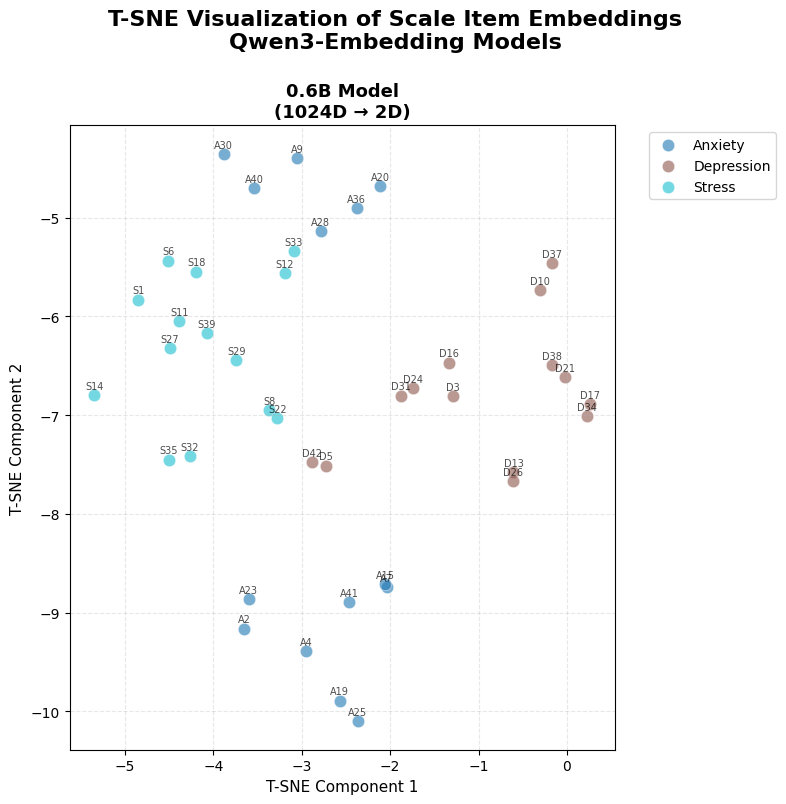


✓ Visualization complete!


In [13]:
# Create T-SNE scatter plots for all models
print("Creating visualizations...")
print("=" * 70)

# Create plots directory if it doesn't exist
plots_dir = "plots"
os.makedirs(plots_dir, exist_ok=True)
print(f"Plots will be saved to: {plots_dir}/")

# Generate timestamp for filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Determine number of models
num_models = len(all_tsne_embeddings)
print(f"Creating plots for {num_models} model(s)...")

# Check if we have any models to plot
if num_models == 0:
    print("\n⚠ WARNING: No T-SNE embeddings available to plot!")
    print("  This could mean:")
    print("  - No models were successfully loaded")
    print("  - Embedding extraction failed for all models")
    print("  - T-SNE failed for all models")
    print("\nSkipping visualization...")
else:
    # Adjust figure size based on number of models
    # Use dynamic sizing, with 3 columns max for better layout
    fig_width = min(24, 8 * num_models)  # Cap at 24 inches
    fig, axes = plt.subplots(1, min(3, num_models), figsize=(fig_width, 8))
    
    # Handle case of single model (axes is not a list in this case)
    if min(3, num_models) == 1:
        axes = [axes]
    
    for idx, (model_size, embeddings_2d) in enumerate(sorted(all_tsne_embeddings.items())):
        if idx >= 3:  # Only plot first 3 models in this cell
            break
            
        ax = axes[idx]
        
        # Plot each factor with a different color
        for factor in unique_factors:
            # Get indices for this factor
            indices = [i for i, f in enumerate(factors) if f == factor]
            
            # Plot points for this factor
            ax.scatter(
                embeddings_2d[indices, 0],
                embeddings_2d[indices, 1],
                c=[factor_to_color[factor]],
                label=factor,
                alpha=0.6,
                s=80,
                edgecolors='white',
                linewidth=0.5
            )
        
        # Add labels for each point using the 'code' column
        for i in range(len(embeddings_2d)):
            ax.annotate(
                codes[i],  # Use the code as the label
                (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                fontsize=7,
                alpha=0.7,
                ha='center',
                va='bottom',
                xytext=(0, 3),  # Offset label slightly above the point
                textcoords='offset points'
            )
        
        # Get embedding dimension for title
        embedding_dim = all_embeddings[model_size].shape[1]
        
        ax.set_xlabel('T-SNE Component 1', fontsize=11)
        ax.set_ylabel('T-SNE Component 2', fontsize=11)
        ax.set_title(
            f'{model_size} Model\n({embedding_dim}D → 2D)',
            fontsize=13,
            fontweight='bold'
        )
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # Only add legend to the rightmost plot
        if idx == min(2, num_models - 1):
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    # Overall title
    fig.suptitle(
        'T-SNE Visualization of Scale Item Embeddings\n'
        'Qwen3-Embedding Models',
        fontsize=16,
        fontweight='bold',
        y=1.00
    )
    
    plt.tight_layout()
    
    # Save the figure
    model_names_str = "_".join(sorted(list(all_tsne_embeddings.keys())[:3]))
    filename = f"qwen3_tsne_visualization_{model_names_str}_{timestamp}.png"
    filepath = os.path.join(plots_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"\n✓ Plot saved to: {filepath}")
    
    # Display the plot
    plt.show()
    
    print("\n✓ Visualization complete!")

## Analyze Nearest Neighbors - All Models

Compare how different model sizes identify semantic neighbors.

In [14]:
# Analyze nearest neighbors in the ORIGINAL high-dimensional space for all models
print("Finding nearest neighbors in original embedding space (not T-SNE)...")
print("=" * 70)

from sklearn.metrics.pairwise import cosine_similarity

print(f"\nSample item #{sample_idx}:")
print(f"  Factor: {factors[sample_idx]}")
print(f"  Text: {items[sample_idx]}")

for model_size, embeddings in sorted(all_embeddings.items()):
    print(f"\n{'='*70}")
    print(f"{model_size} Model - Original {embeddings.shape[1]}D Space")
    print(f"{'='*70}")
    
    # Compute cosine similarity between sample and all items
    similarities = cosine_similarity([embeddings[sample_idx]], embeddings)[0]
    
    # Find 5 most similar items (excluding itself)
    most_similar_indices = np.argsort(similarities)[::-1][1:6]
    
    print(f"5 Most similar items (by cosine similarity):")
    for rank, idx in enumerate(most_similar_indices, 1):
        print(f"  {rank}. [{factors[idx]}] {items[idx]}")
        print(f"      Similarity: {similarities[idx]:.4f}")

Finding nearest neighbors in original embedding space (not T-SNE)...

Sample item #0:
  Factor: Stress
  Text: I found myself getting upset by quite trivial things.

0.6B Model - Original 1024D Space
5 Most similar items (by cosine similarity):
  1. [Stress] I found myself getting upset rather easily.
      Similarity: 0.8722
  2. [Stress] I found myself getting agitated.
      Similarity: 0.7611
  3. [Stress] I found that I was very irritable.
      Similarity: 0.7597
  4. [Stress] I found it hard to calm down after something upset me.
      Similarity: 0.7579
  5. [Stress] I felt that I was rather touchy.
      Similarity: 0.7467


## Quantify Factor Separation

Measure how well the embeddings separate the three DASS factors (Anxiety, Depression, Stress) using cosine similarity analysis.

**Metrics:**
- **Within-factor similarity**: Average cosine similarity between items in the same factor
- **Between-factor similarity**: Average cosine similarity between items in different factors  
- **Separation ratio**: Within / Between (higher = better separation, >1.0 means factors cluster together)

In [15]:
print("Computing factor separation metrics...")
print("=" * 70)

# Loop through all models
for model_size, embeddings in sorted(all_embeddings.items()):
    print(f"\n{'='*70}")
    print(f"{model_size} Model - Factor Separation Analysis")
    print(f"{'='*70}")
    
    # Compute full similarity matrix
    sim_matrix = cosine_similarity(embeddings)
    
    # Initialize accumulators
    within_factor_sims = {factor: [] for factor in unique_factors}
    between_factor_sims = []
    
    # Compute within-factor and between-factor similarities
    for i in range(len(items)):
        for j in range(i + 1, len(items)):  # Only upper triangle (avoid duplicates)
            similarity = sim_matrix[i, j]
            
            if factors[i] == factors[j]:
                # Same factor - within-factor similarity
                within_factor_sims[factors[i]].append(similarity)
            else:
                # Different factors - between-factor similarity
                between_factor_sims.append(similarity)
    
    # Compute overall metrics
    all_within_sims = []
    for factor_sims in within_factor_sims.values():
        all_within_sims.extend(factor_sims)
    
    within_mean = np.mean(all_within_sims)
    between_mean = np.mean(between_factor_sims)
    separation_ratio = within_mean / between_mean
    
    # Print overall results
    print(f"\nOverall Separation Metrics:")
    print(f"  Within-factor similarity:  {within_mean:.4f}")
    print(f"  Between-factor similarity: {between_mean:.4f}")
    print(f"  Separation ratio:          {separation_ratio:.4f}")
    print(f"    {'(Good separation - factors cluster together!)' if separation_ratio > 1.0 else '(Poor separation - factors overlap)'}")
    
    # Print per-factor breakdown
    print(f"\nPer-Factor Within-Similarity:")
    for factor in unique_factors:
        factor_mean = np.mean(within_factor_sims[factor])
        factor_std = np.std(within_factor_sims[factor])
        n_pairs = len(within_factor_sims[factor])
        print(f"  {factor:12s}: {factor_mean:.4f} ± {factor_std:.4f}  (n={n_pairs} pairs)")
    
    # Compute pairwise between-factor similarities
    print(f"\nBetween-Factor Similarities:")
    factor_pairs = {}
    for i in range(len(items)):
        for j in range(i + 1, len(items)):
            if factors[i] != factors[j]:
                pair = tuple(sorted([factors[i], factors[j]]))
                if pair not in factor_pairs:
                    factor_pairs[pair] = []
                factor_pairs[pair].append(sim_matrix[i, j])
    
    for pair in sorted(factor_pairs.keys()):
        pair_mean = np.mean(factor_pairs[pair])
        pair_std = np.std(factor_pairs[pair])
        n_pairs = len(factor_pairs[pair])
        print(f"  {pair[0]:12s} vs {pair[1]:12s}: {pair_mean:.4f} ± {pair_std:.4f}  (n={n_pairs} pairs)")

print(f"\n{'='*70}")
print("Factor separation analysis complete!")
print(f"{'='*70}")

Computing factor separation metrics...

0.6B Model - Factor Separation Analysis

Overall Separation Metrics:
  Within-factor similarity:  0.6528
  Between-factor similarity: 0.5538
  Separation ratio:          1.1788
    (Good separation - factors cluster together!)

Per-Factor Within-Similarity:
  Anxiety     : 0.6009 ± 0.0940  (n=91 pairs)
  Depression  : 0.6577 ± 0.0963  (n=91 pairs)
  Stress      : 0.6998 ± 0.0778  (n=91 pairs)

Between-Factor Similarities:
  Anxiety      vs Depression  : 0.5140 ± 0.0640  (n=196 pairs)
  Anxiety      vs Stress      : 0.5814 ± 0.0768  (n=196 pairs)
  Depression   vs Stress      : 0.5659 ± 0.0703  (n=196 pairs)

Factor separation analysis complete!


## Calculate Factor Centroids

Compute the mean embedding (centroid) for each of the three DASS factors. These centroids represent the "average" embedding for each psychological dimension and can be used for further analysis.

In [16]:
print("Calculating factor centroids...")
print("=" * 70)

# Dictionary to store centroids for all models
all_centroids = {}

# Loop through all models
for model_size, embeddings in sorted(all_embeddings.items()):
    print(f"\n{'='*70}")
    print(f"{model_size} Model - Computing Centroids")
    print(f"{'='*70}")
    
    # Initialize centroid dictionary for this model
    centroids = {}
    
    # Calculate centroid (mean embedding) for each factor
    for factor in unique_factors:
        # Get indices of items belonging to this factor
        factor_indices = [i for i, f in enumerate(factors) if f == factor]
        
        # Get embeddings for this factor
        factor_embeddings = embeddings[factor_indices]
        
        # Compute centroid (mean of all embeddings in this factor)
        centroid = np.mean(factor_embeddings, axis=0)
        
        # Store centroid
        centroids[factor] = centroid
        
        # Print info
        print(f"\n{factor}:")
        print(f"  Number of items: {len(factor_indices)}")
        print(f"  Centroid shape: {centroid.shape}")
        print(f"  Centroid norm: {np.linalg.norm(centroid):.4f}")
    
    # Store centroids for this model
    all_centroids[model_size] = centroids

print(f"\n{'='*70}")
print("Centroid calculation complete!")
print(f"{'='*70}")
print(f"\nCentroids stored in 'all_centroids' dictionary:")
print(f"  Structure: all_centroids[model_size][factor] = centroid_vector")
print(f"  Models: {list(all_centroids.keys())}")
print(f"  Factors per model: {list(all_centroids[list(all_centroids.keys())[0]].keys())}")

Calculating factor centroids...

0.6B Model - Computing Centroids

Anxiety:
  Number of items: 14
  Centroid shape: (1024,)
  Centroid norm: 0.7933

Depression:
  Number of items: 14
  Centroid shape: (1024,)
  Centroid norm: 0.8259

Stress:
  Number of items: 14
  Centroid shape: (1024,)
  Centroid norm: 0.8492

Centroid calculation complete!

Centroids stored in 'all_centroids' dictionary:
  Structure: all_centroids[model_size][factor] = centroid_vector
  Models: ['0.6B']
  Factors per model: ['Anxiety', 'Depression', 'Stress']


## Find Nearest Neighbor Words for Factor Centroids

Using the computed factor centroids, we'll find the most semantically similar words from a large vocabulary. This analysis identifies which common English words are closest to each psychological dimension.

**Process:**
1. Load 60,000 common English words from wordfreq dataset
2. Generate embeddings for all words using the same model(s)
3. Compute cosine similarity between each factor centroid and all word embeddings
4. Display top 10 nearest neighbor words for each factor (Anxiety, Depression, Stress)

In [17]:
# Load word list
print("Loading word list from dataset...")
print("=" * 70)

word_list_path = "word_lists/wordfreq_top60000_with_constructs.csv"
words_df = pd.read_csv(word_list_path, header=None, names=['word'])
words = words_df['word'].tolist()

print(f"✓ Loaded {len(words):,} words")
print(f"Sample words: {words[:10]}")
print(f"Last 5 words: {words[-5:]}")

# Dictionary to store word embeddings for all models
all_word_embeddings = {}

# Generate embeddings for all words using each model
print(f"\n{'='*70}")
print("Generating embeddings for words...")
print(f"{'='*70}")

for model_size, model in sorted(all_models.items()):
    print(f"\n{'='*70}")
    print(f"{model_size} Model - Encoding {len(words):,} words")
    print(f"{'='*70}")
    print("This may take 2-5 minutes depending on model size and device...")
    
    # Encode all words in batches
    word_embeddings = model.encode(
        words,
        batch_size=32,  # Larger batch size for single words
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True  # Normalize for cosine similarity
    )
    
    all_word_embeddings[model_size] = word_embeddings
    
    print(f"✓ Word embeddings generated!")
    print(f"  Shape: {word_embeddings.shape}")
    print(f"  ({word_embeddings.shape[0]:,} words × {word_embeddings.shape[1]} dimensions)")

print(f"\n{'='*70}")
print("✓ All word embeddings generated!")
print(f"{'='*70}")

Loading word list from dataset...
✓ Loaded 72,421 words
Sample words: ['word', '0', '0f', '0s', '1', '1a', '1am', '1b', '1bn', '1c']
Last 5 words: ['🤮', '🤷\u200d♀️', '🤷\u200d♂️', '🤷🏻\u200d♀️', '🥰']

Generating embeddings for words...

0.6B Model - Encoding 72,421 words
This may take 2-5 minutes depending on model size and device...


Batches: 100%|██████████| 2264/2264 [03:48<00:00,  9.92it/s]


✓ Word embeddings generated!
  Shape: (72421, 1024)
  (72,421 words × 1024 dimensions)

✓ All word embeddings generated!


In [18]:
# Find nearest neighbor words for each factor centroid
print("Finding nearest neighbor words for each factor centroid...")
print("=" * 70)

# Process each model
for model_size in sorted(all_models.keys()):
    print(f"\n{'='*70}")
    print(f"{model_size} Model - Nearest Neighbor Words")
    print(f"{'='*70}")
    
    # Get centroids and word embeddings for this model
    centroids = all_centroids[model_size]
    word_embeddings = all_word_embeddings[model_size]
    
    # Normalize centroids for cosine similarity (if not already normalized)
    normalized_centroids = {}
    for factor, centroid in centroids.items():
        norm = np.linalg.norm(centroid)
        normalized_centroids[factor] = centroid / norm if norm > 0 else centroid
    
    # For each factor, find top 10 nearest neighbor words
    for factor in unique_factors:
        print(f"\n{'-'*70}")
        print(f"Factor: {factor}")
        print(f"{'-'*70}")
        
        # Compute cosine similarity between this factor's centroid and all word embeddings
        centroid = normalized_centroids[factor]
        similarities = cosine_similarity([centroid], word_embeddings)[0]
        
        # Get indices of top 10 most similar words
        top_indices = np.argsort(similarities)[::-1][:10]
        
        # Display results
        print(f"\nTop 10 nearest neighbor words:")
        print(f"{'Rank':<6} {'Word':<20} {'Similarity':<12}")
        print("-" * 40)
        for rank, idx in enumerate(top_indices, 1):
            word = words[idx]
            similarity = similarities[idx]
            print(f"{rank:<6} {word:<20} {similarity:.4f}")

print(f"\n{'='*70}")
print("✓ Nearest neighbor analysis complete!")
print(f"{'='*70}")

Finding nearest neighbor words for each factor centroid...

0.6B Model - Nearest Neighbor Words

----------------------------------------------------------------------
Factor: Anxiety
----------------------------------------------------------------------

Top 10 nearest neighbor words:
Rank   Word                 Similarity  
----------------------------------------
1      pain-fear            0.7508
2      shuddered            0.7474
3      shudders             0.7294
4      squeaked             0.7271
5      social anxiety       0.7271
6      speech anxiety       0.7251
7      specific phobia      0.7193
8      pain-related-fear    0.7154
9      death anxiety        0.7137
10     hyperventilation     0.7133

----------------------------------------------------------------------
Factor: Depression
----------------------------------------------------------------------

Top 10 nearest neighbor words:
Rank   Word                 Similarity  
----------------------------------------
1    

## Test Factor Label Names Against Their Own Centroids

Automatically test how well the factor label names (e.g., "Agreeableness", "Neuroticism") match their own factor centroids. This reveals whether the conventional psychological labels align with the semantic content of their constituent items.

In [19]:
# Automatically use factor names from the scale
factor_names = unique_factors  # Already extracted from the scale CSV

print(f"Testing {len(factor_names)} factor label name(s) against factor centroids...")
print("=" * 70)
print(f"Factor names: {factor_names}\n")

# Generate embeddings for factor names using each model
factor_name_embeddings = {}

for model_size, model in sorted(all_models.items()):
    print(f"{'='*70}")
    print(f"{model_size} Model - Encoding {len(factor_names)} factor names")
    print(f"{'='*70}")
    
    # Encode factor names
    embeddings = model.encode(
        factor_names,
        batch_size=32,
        show_progress_bar=False,
        convert_to_numpy=True,
        normalize_embeddings=True  # Normalize for cosine similarity
    )
    
    factor_name_embeddings[model_size] = embeddings
    print(f"✓ Factor name embeddings generated!")
    print(f"  Shape: {embeddings.shape}\n")

# Compute similarities for each model
for model_size in sorted(all_models.keys()):
    print(f"{'='*70}")
    print(f"{model_size} Model - Factor Name Similarities")
    print(f"{'='*70}")
    
    # Get centroids and factor name embeddings for this model
    centroids = all_centroids[model_size]
    embeddings = factor_name_embeddings[model_size]
    
    # Normalize centroids
    normalized_centroids = {}
    for factor, centroid in centroids.items():
        norm = np.linalg.norm(centroid)
        normalized_centroids[factor] = centroid / norm if norm > 0 else centroid
    
    # Compute similarity matrix: factor names × factor centroids
    similarity_matrix = np.zeros((len(factor_names), len(unique_factors)))
    
    for factor_idx, factor in enumerate(unique_factors):
        centroid = normalized_centroids[factor]
        similarities = cosine_similarity([centroid], embeddings)[0]
        similarity_matrix[:, factor_idx] = similarities
    
    # Create DataFrame for easy viewing
    results_df = pd.DataFrame(
        similarity_matrix,
        columns=unique_factors,
        index=factor_names
    )
    
    # Add a column for the highest similarity factor
    results_df['Highest'] = results_df.idxmax(axis=1)
    results_df['Max_Sim'] = results_df[unique_factors].max(axis=1)
    
    # Sort by maximum similarity (descending)
    results_df = results_df.sort_values('Max_Sim', ascending=False)
    
    # Display results in a clearer format
    print(f"\nSimilarity scores for {len(factor_names)} factor label name(s):")
    print(f"(Sorted by maximum similarity)\n")
    
    # Display each factor name with its similarities
    for factor_name in results_df.index:
        max_factor = results_df.loc[factor_name, 'Highest']
        max_sim = results_df.loc[factor_name, 'Max_Sim']
        
        # Check if the factor name matches its own centroid
        is_correct = (factor_name == max_factor)
        marker = "✓" if is_correct else "✗"
        
        print(f"\n{factor_name}: {marker}")
        print(f"  → {max_factor}: {max_sim:.4f} ★")
        
        # Show other factors
        for factor in unique_factors:
            if factor != max_factor:
                sim = results_df.loc[factor_name, factor]
                # Highlight if this is the "correct" factor
                if factor == factor_name:
                    print(f"  → {factor}: {sim:.4f} (expected match)")
                else:
                    print(f"  → {factor}: {sim:.4f}")
    
    # Summary statistics
    print(f"\n{'='*70}")
    print("Summary Statistics:")
    print(f"{'='*70}")
    
    # Count how many factor names correctly matched their centroids
    correct_matches = sum(results_df.index == results_df['Highest'])
    print(f"Correct matches: {correct_matches}/{len(factor_names)} ({correct_matches/len(factor_names)*100:.1f}%)\n")
    
    for factor in unique_factors:
        mean_sim = results_df[factor].mean()
        max_sim = results_df[factor].max()
        max_word = results_df[factor].idxmax()
        # Check if this factor's name is the best match
        self_match = results_df.loc[factor, factor] if factor in results_df.index else 0.0
        print(f"{factor:20s} → Mean: {mean_sim:.4f}, Max: {max_sim:.4f} ({max_word}), Self: {self_match:.4f}")

print(f"\n{'='*70}")
print("✓ Factor name analysis complete!")
print(f"{'='*70}")

Testing 3 factor label name(s) against factor centroids...
Factor names: ['Anxiety', 'Depression', 'Stress']

0.6B Model - Encoding 3 factor names
✓ Factor name embeddings generated!
  Shape: (3, 1024)

0.6B Model - Factor Name Similarities

Similarity scores for 3 factor label name(s):
(Sorted by maximum similarity)


Anxiety: ✓
  → Anxiety: 0.6843 ★
  → Depression: 0.5335
  → Stress: 0.6489

Stress: ✓
  → Stress: 0.6489 ★
  → Anxiety: 0.6105
  → Depression: 0.5327

Depression: ✓
  → Depression: 0.6255 ★
  → Anxiety: 0.5950
  → Stress: 0.5597

Summary Statistics:
Correct matches: 3/3 (100.0%)

Anxiety              → Mean: 0.6300, Max: 0.6843 (Anxiety), Self: 0.6843
Depression           → Mean: 0.5639, Max: 0.6255 (Depression), Self: 0.6255
Stress               → Mean: 0.6192, Max: 0.6489 (Anxiety), Self: 0.6489

✓ Factor name analysis complete!


## Test Specific Words Against Factor Centroids

Specify custom words to test their similarity against each factor centroid. This is useful for:
- Testing theoretically-relevant psychological constructs
- Validating expected associations
- Exploring semantic relationships with specific terms

In [ ]:
# ============================================================================
# SPECIFY CUSTOM WORDS TO TEST
# ============================================================================
# Option 1: Manually specify words
custom_words = [
    # Add your words here, one per line
    # Example: "happiness", "sadness", "anger"
]

# Option 2: Load from constructs.csv (uncomment to use)
# constructs_df = pd.read_csv("word_lists/constructs.csv")
# custom_words = constructs_df['word'].tolist()

# Option 3: Select specific constructs from the file (uncomment to use)
# constructs_df = pd.read_csv("word_lists/constructs.csv")
# custom_words = constructs_df['word'].tolist()[:50]  # First 50 constructs

# ============================================================================

# Skip this analysis if no words specified
if not custom_words:
    print("No custom words specified. Skipping this analysis.")
    print("\nTo use this cell:")
    print("  1. Add words to the 'custom_words' list above, OR")
    print("  2. Uncomment one of the constructs.csv loading options")
else:
    print(f"Testing {len(custom_words)} custom word(s) against factor centroids...")
    print("=" * 70)
    
    # Generate embeddings for custom words using each model
    custom_word_embeddings = {}
    
    for model_size, model in sorted(all_models.items()):
        print(f"\n{'='*70}")
        print(f"{model_size} Model - Encoding {len(custom_words)} custom words")
        print(f"{'='*70}")
        
        # Encode custom words
        embeddings = model.encode(
            custom_words,
            batch_size=32,
            show_progress_bar=False,
            convert_to_numpy=True,
            normalize_embeddings=True  # Normalize for cosine similarity
        )
        
        custom_word_embeddings[model_size] = embeddings
        print(f"✓ Custom word embeddings generated!")
        print(f"  Shape: {embeddings.shape}")
    
    # Compute similarities for each model
    for model_size in sorted(all_models.keys()):
        print(f"\n{'='*70}")
        print(f"{model_size} Model - Custom Word Similarities")
        print(f"{'='*70}")
        
        # Get centroids and custom word embeddings for this model
        centroids = all_centroids[model_size]
        embeddings = custom_word_embeddings[model_size]
        
        # Normalize centroids
        normalized_centroids = {}
        for factor, centroid in centroids.items():
            norm = np.linalg.norm(centroid)
            normalized_centroids[factor] = centroid / norm if norm > 0 else centroid
        
        # Compute similarity matrix: words × factors
        similarity_matrix = np.zeros((len(custom_words), len(unique_factors)))
        
        for factor_idx, factor in enumerate(unique_factors):
            centroid = normalized_centroids[factor]
            similarities = cosine_similarity([centroid], embeddings)[0]
            similarity_matrix[:, factor_idx] = similarities
        
        # Create DataFrame for easy viewing
        results_df = pd.DataFrame(
            similarity_matrix,
            columns=unique_factors,
            index=custom_words
        )
        
        # Add a column for the highest similarity factor
        results_df['Highest'] = results_df.idxmax(axis=1)
        results_df['Max_Sim'] = results_df[unique_factors].max(axis=1)
        
        # Sort by maximum similarity (descending)
        results_df = results_df.sort_values('Max_Sim', ascending=False)
        
        # Display results in a clearer format
        print(f"\nSimilarity scores for {len(custom_words)} custom word(s):")
        print(f"(Sorted by maximum similarity)\n")
        
        # Display each word with its similarities
        for word in results_df.index:
            max_factor = results_df.loc[word, 'Highest']
            max_sim = results_df.loc[word, 'Max_Sim']
            
            print(f"\n{word}:")
            print(f"  → {max_factor}: {max_sim:.4f} ★")
            
            # Show other factors
            for factor in unique_factors:
                if factor != max_factor:
                    sim = results_df.loc[word, factor]
                    print(f"  → {factor}: {sim:.4f}")
        
        # Summary statistics
        print(f"\n{'='*70}")
        print("Summary Statistics:")
        print(f"{'='*70}")
        for factor in unique_factors:
            mean_sim = results_df[factor].mean()
            max_sim = results_df[factor].max()
            max_word = results_df[factor].idxmax()
            print(f"{factor:20s} → Mean: {mean_sim:.4f}, Max: {max_sim:.4f} ({max_word})")
    
    print(f"\n{'='*70}")
    print("✓ Custom word analysis complete!")
    print(f"{'='*70}")

No custom words specified. Skipping this analysis.

To use this cell:
  1. Add words to the 'custom_words' list above, OR
  2. Uncomment one of the constructs.csv loading options


: 